# Connect Four AI

Wassup! I have no idea what I'm doing, but here goes.

So I _finally_ coded up a working Connect Four game in Python, and now comes the fun part. I'm going to follow the style of the tutorial on Medium and start with a simple Q-table implementation.

In [1]:
from ConnectFour import Game
import numpy as np

g = Game()
g.play(0) # player 1 move
g.play(0) # player 2 move
g.play(1) # and back to player 1

(array([[[ 1.,  1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]), 0, False)

Above is a sample output of what the computer gets for each move: a "reward" (only nonzero when you win/lose), the state of the board, and an indication of whether the game is over or not.

## Constructing the Neural Network

In [1]:
from ConnectFour import Game
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

g = Game()

# constructing the network
tf.reset_default_graph()
inputs1 = tf.placeholder(shape=[1,84], dtype=tf.float32) # the input is the current state, i.e. the entire board
W = tf.Variable(tf.random_uniform([84,7], 0, 0.1)) # the weights for a single layer network are this
Qout = tf.matmul(inputs1, W) # predicting Q values using network
predict = tf.argmax(Qout, 1) # finding best predicted action from Qout

# constructing the loss function
nextQ = tf.placeholder(shape=[1,7], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
updateModel = trainer.minimize(loss)

# some magic initializer or something, and a saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# hyperparameters
y = 0.99 # discount rate for Bellman equation
e = 0.1 # chance of random action being taken
n_episodes = 2000

jList = [] # number of steps for each game
rList = [] # maximum reward for each game

# with tf.Session() as sess:
#     sess.run(init)
    
#     # save the current model to file
#     savePath = saver.save(sess, './model_init.ckpt')
#     print('Initial model config saved to {}'.format(savePath))
    
#     for i in range(n_episodes):
#         if i%100 is 0:
#             print('On episode {}'.format(i))
        
#         # reset the game
#         g.reset()
#         rAll = 0
#         d = False
#         j = 0
#         while j < 99:
#             j += 1
#             s = g.getState()
#             a, allQ = sess.run([predict, Qout], feed_dict={inputs1:s.reshape((1,84))})
#             if np.random.rand(1) < e:
#                 a[0] = np.random.randint(7) # pick a random move
#             # make the move, get the reward and whatnot
#             while True: # ensures it makes a move
#                 try:
#                     s1, r, d = g.play(a[0])
#                     break
#                 except:
#                     # first check if game is still playable
#                     if g.isPlayable():
#                         a[0] = np.random.randint(7)
#                     else:
#                         s1 = s
#                         r = 0
#                         d = True
#                         break
#             Q1 = sess.run(Qout, {inputs1:s1.reshape((1,84))})
#             maxQ1 = np.max(Q1)
#             targetQ = allQ
#             # not sure why it's 0, a[0] here... Wait, I think it's because
#             # targetQ is 1x7 vector, and only want to update the Q value for
#             # the given state/action pair
#             targetQ[0, a[0]] = r + y*maxQ1
#             # train model based on new value
#             _, W1 = sess.run([updateModel, W], {inputs1: s.reshape((1,84)), nextQ: targetQ})
#             rAll += r
            
#             if d:
#                 e = 1. / ((i/50.) + 10)
#                 break
        
#         jList.append(j)
#         rList.append(rAll)
    
#     # save the current model to file
#     savePath = saver.save(sess, './model.ckpt')
#     print('Trained model saved to {}'.format(savePath))

# print('Percent successful episodes: {}%'.format(sum(rList)/n_episodes * 100))

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


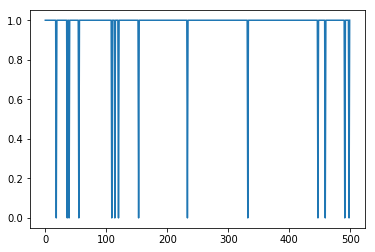

In [3]:
plt.plot(rList)

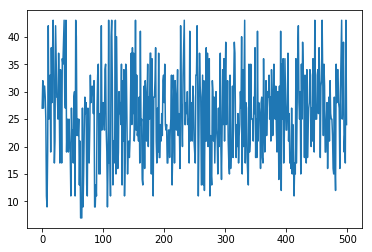

In [4]:
plt.plot(jList)

### So... What did I just do?

I'm not really sure, but the computer did run 2000 episodes of Connect Four and (possibly) trained the Q-network to play. I'm not really sure how to test it, and I've got to run to practice now, but I'll return to this when I get back.

Ok! So I messed around with some stuff above to save/reload models, and now below I'm going to try to implement a me-vs-machine game thingy.

In [6]:
# create a game
g = Game()

with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    
    d = False
    while not d:
        print(g)
        # get human input
        while True:
            try:
                play = int(input("Human, enter move: ")) - 1
                print("the play is {}".format(play))
                _, r, d = g.play(play)
                break
            except:
                if g.isPlayable():
                    print("Error, try again")
                else:
                    d = True
                    break
        if d:
            break
        # then get computer input, first predict best move from Q-network
        print("Computer is thinking...")
        s = g.getState()
        a, allQ = sess.run([predict, Qout], {inputs1: s.reshape((1,84))})
        # then make the move
        print("Computer is making move...")
        while True:
            try:
                _, r, d = g.play(a[0])
                break
            except:
                if g.isPlayable():
                    a[0] = np.random.randint(7)
                else:
                    d = True
                    break
        print("Computer made move.")
    print("Winner was {}".format(g.getWinner()))

INFO:tensorflow:Restoring parameters from ./model.ckpt
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter move: 1
the play is 0
Computer is thinking...
Computer is making move...
Computer made move.
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
2	-	-	-	-	-	-	
1	-	-	-	-	-	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter move: 1
the play is 0
Computer is thinking...
Computer is making move...
Computer made move.
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
1	-	-	-	-	-	-	
2	-	-	-	-	-	-	
1	-	-	2	-	-	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter move: 1
the play is 0
Computer is thinking...
Computer is making move...
Computer made move.
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
1	-	-	-	-	-	-	
1	-	-	-	-	-	-	
2	-	-	2	-	-	-	
1	-	-	2	-	-	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter mo